# 📈 Predicción de Series de Tiempo de Delitos con Spark ML
## Enfoque Escalable con Regresión Supervisada

---

### Objetivos:
1.  **Carga y Limpieza**: Procesar dataset masivo de delitos (filtrado >= 2016).
2.  **Ingeniería de Características**: Transformar serie temporal en problema supervisado (Lags, Ventanas Móviles).
3.  **Entrenamiento**: Ajustar modelos (LR, RF, GBT) y evaluar rendimiento en datos de entrenamiento.
4.  **Evaluación Final**: Validar el mejor modelo en datos de prueba (no vistos) para medir capacidad de generalización.

**Autor**: Adonnay Bazaldua (Asistente AI)
**Fecha**: Diciembre 2025

## 1. Configuración de Spark Session

In [1]:
import os
import sys

# Configurar PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Spark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Visualización
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Iniciar Spark Session
spark = (SparkSession.builder
         .appName("Crime_TimeSeries_SparkML")
         .master("local[*]")
         .config("spark.driver.memory", "8g")
         .config("spark.executor.memory", "8g")
         .config("spark.sql.shuffle.partitions", "200")
         .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")

print(f"✅ Spark Session iniciada: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/03 00:41:30 WARN Utils: Your hostname, kissabella, resolves to a loopback address: 127.0.1.1; using 192.168.1.87 instead (on interface wlo1)
25/12/03 00:41:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/03 00:41:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session iniciada: 4.0.1


## 2. Carga y Preparación de Datos

In [2]:
# Ruta del dataset
parquet_path = "/home/adonnay_bazaldua/Documentos/GitHub/Crime-Analysis-in-Mexico-City-using-Neural-Networks/data/delitos_cdmx.parquet"

print("⏳ Cargando dataset...")
df = spark.read.parquet(parquet_path)

# Filtrar datos a partir de 2016 y columnas relevantes
print("⏳ Filtrando datos (año >= 2016)...")
df_filtered = df.filter(F.col("anio_hecho") >= 2016)

# Seleccionar solo fecha y conteo para la serie temporal global
# Nota: Se puede refinar por categoría si se desea predecir un tipo específico
df_ts = df_filtered.select("fecha_hecho") \
    .withColumn("fecha", F.to_date(F.col("fecha_hecho")))

# Agregación Diaria
daily_counts = df_ts.groupBy("fecha") \
    .agg(F.count("*").alias("total_delitos")) \
    .orderBy("fecha")

# Llenar días faltantes (si los hay) con 0 es buena práctica en series de tiempo,
# aunque en delitos de CDMX es raro tener 0 delitos en un día.
# Por ahora asumimos continuidad.

print(f"✅ Datos agregados por día. Total de registros: {daily_counts.count()}")
daily_counts.show(5)

⏳ Cargando dataset...


⏳ Filtrando datos (año >= 2016)...


✅ Datos agregados por día. Total de registros: 3319


+----------+-------------+
|     fecha|total_delitos|
+----------+-------------+
|2016-01-01|          625|
|2016-01-02|          401|
|2016-01-03|          385|
|2016-01-04|          582|
|2016-01-05|          539|
+----------+-------------+
only showing top 5 rows


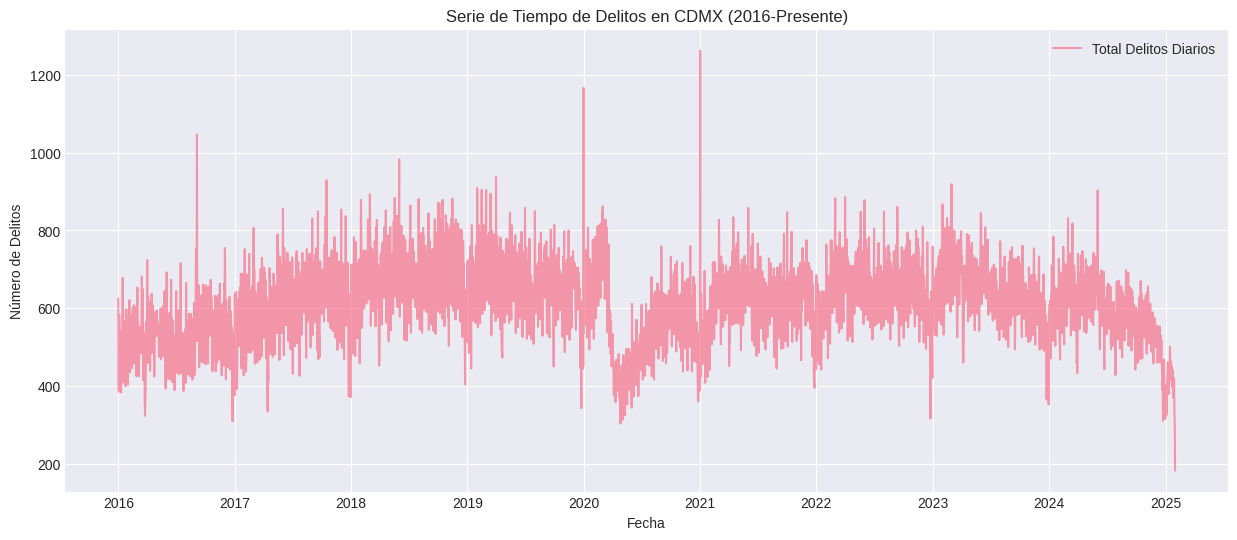

⏳ Generando descomposición estacional...


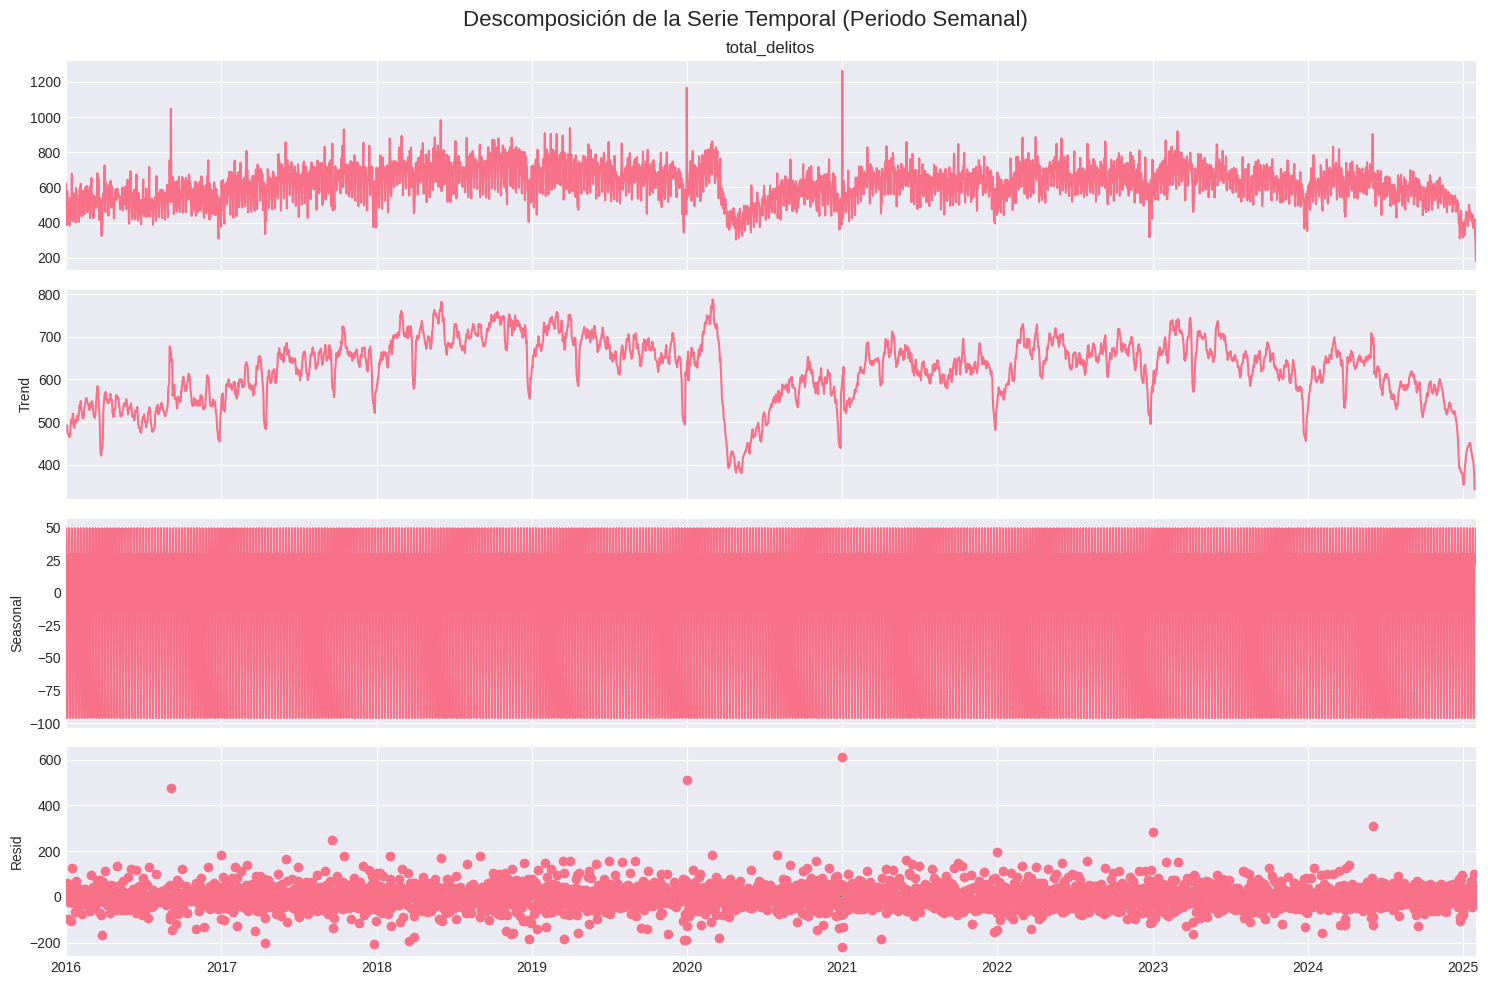

⏳ Generando gráficos de autocorrelación...


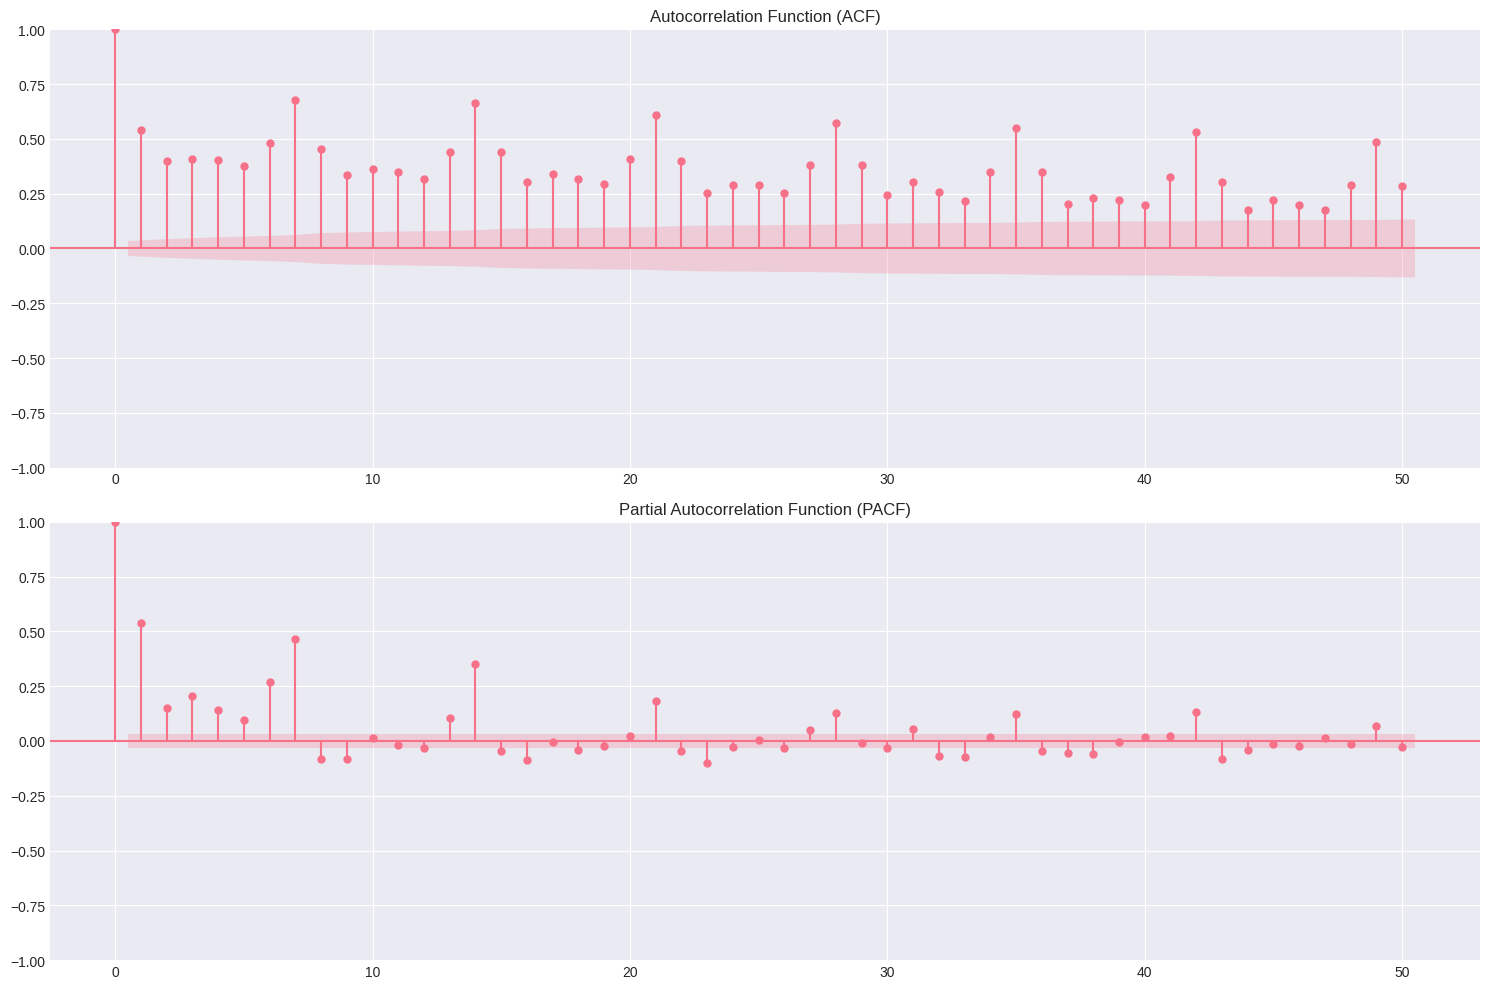


🔍 **Discusión de Patrones Observados**:
1. **Tendencia**: Se observa la evolución a largo plazo de los delitos. Es probable ver caídas en periodos específicos (ej. pandemia 2020).
2. **Estacionalidad Semanal**: La descomposición con periodo 7 debería mostrar patrones claros de días con más/menos delitos (ej. fines de semana vs días laborales).
3. **Autocorrelación**: 
   - El ACF muestra qué tanto influyen los días pasados en el actual. Picos altos en lag 7, 14, 21 confirman la estacionalidad semanal.
   - El PACF ayuda a determinar cuántos lags son realmente significativos para un modelo AR (AutoRegresivo).



In [3]:
# Análisis Exploratorio de Datos (EDA)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Convertir a Pandas para visualización
pdf_daily = daily_counts.toPandas()
pdf_daily['fecha'] = pd.to_datetime(pdf_daily['fecha'])
pdf_daily.set_index('fecha', inplace=True)

# 1. Gráfica de la Serie Temporal
plt.figure(figsize=(15, 6))
plt.plot(pdf_daily.index, pdf_daily['total_delitos'], label='Total Delitos Diarios', alpha=0.7)
plt.title('Serie de Tiempo de Delitos en CDMX (2016-Presente)')
plt.xlabel('Fecha')
plt.ylabel('Número de Delitos')
plt.legend()
plt.show()

# 2. Descomposición Estacional (Tendencia, Estacionalidad, Residuo)
# Usamos periodo=7 para estacionalidad semanal, o 365 para anual. 
# Dado el ruido diario, empezamos con semanal.
print("⏳ Generando descomposición estacional...")
decomposition = seasonal_decompose(pdf_daily['total_delitos'], model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.suptitle('Descomposición de la Serie Temporal (Periodo Semanal)', fontsize=16)
plt.tight_layout()
plt.show()

# 3. ACF y PACF
print("⏳ Generando gráficos de autocorrelación...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(pdf_daily['total_delitos'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(pdf_daily['total_delitos'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# Discusión de Patrones
print("""
🔍 **Discusión de Patrones Observados**:
1. **Tendencia**: Se observa la evolución a largo plazo de los delitos. Es probable ver caídas en periodos específicos (ej. pandemia 2020).
2. **Estacionalidad Semanal**: La descomposición con periodo 7 debería mostrar patrones claros de días con más/menos delitos (ej. fines de semana vs días laborales).
3. **Autocorrelación**: 
   - El ACF muestra qué tanto influyen los días pasados en el actual. Picos altos en lag 7, 14, 21 confirman la estacionalidad semanal.
   - El PACF ayuda a determinar cuántos lags son realmente significativos para un modelo AR (AutoRegresivo).
""")


## 3. Feature Engineering (Transformación a Supervisado)

In [4]:
print("⚙️ Generando características temporales (Lags y Ventanas)...")

# Definir ventana para lags (ordenar por fecha)
windowSpec = Window.orderBy("fecha")

# 1. Crear Lags (valores pasados)
# Usaremos lags de 1 a 7 días (semana) y 30 días (mes)
lags = [1, 2, 3, 4, 5, 6, 7, 14, 30]
for lag in lags:
    daily_counts = daily_counts.withColumn(f"lag_{lag}", F.lag("total_delitos", lag).over(windowSpec))

# 2. Crear Rolling Statistics (Media móvil)
# Ventana de 7 días (promedio de la última semana)
windowRolling7 = Window.orderBy("fecha").rowsBetween(-7, -1)
daily_counts = daily_counts.withColumn("rolling_mean_7", F.avg("total_delitos").over(windowRolling7))
daily_counts = daily_counts.withColumn("rolling_std_7", F.stddev("total_delitos").over(windowRolling7))

# Ventana de 30 días
windowRolling30 = Window.orderBy("fecha").rowsBetween(-30, -1)
daily_counts = daily_counts.withColumn("rolling_mean_30", F.avg("total_delitos").over(windowRolling30))

# 3. Features de Calendario
daily_counts = daily_counts.withColumn("day_of_week", F.dayofweek("fecha")) \
                           .withColumn("day_of_month", F.dayofmonth("fecha")) \
                           .withColumn("month", F.month("fecha")) \
                           .withColumn("is_weekend", F.when(F.col("day_of_week").isin([1, 7]), 1).otherwise(0))

# Eliminar filas con nulos (generados por los lags)
df_model = daily_counts.na.drop()

print(f"✅ Features generadas. Registros finales para modelado: {df_model.count()}")
df_model.show(5)

⚙️ Generando características temporales (Lags y Ventanas)...


✅ Features generadas. Registros finales para modelado: 3289


+----------+-------------+-----+-----+-----+-----+-----+-----+-----+------+------+------------------+------------------+------------------+-----------+------------+-----+----------+
|     fecha|total_delitos|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|lag_7|lag_14|lag_30|    rolling_mean_7|     rolling_std_7|   rolling_mean_30|day_of_week|day_of_month|month|is_weekend|
+----------+-------------+-----+-----+-----+-----+-----+-----+-----+------+------+------------------+------------------+------------------+-----------+------------+-----+----------+
|2016-01-31|          404|  494|  514|  503|  541|  552|  597|  399|   409|   625| 514.2857142857143|61.654181490293865|             495.6|          1|          31|    1|         1|
|2016-02-01|          523|  404|  494|  514|  503|  541|  552|  597|   524|   401|             515.0| 60.10546286874985|488.23333333333335|          2|           1|    2|         0|
|2016-02-02|          585|  523|  404|  494|  514|  503|  541|  552|   498|   385|504.4285

## 4. División Train/Test (Time Series Split)

In [5]:
# En series de tiempo NO podemos usar randomSplit.
# Debemos cortar por fecha.

# Usaremos el último año (o 20%) para test
split_date = "2024-01-01"

train_df = df_model.filter(F.col("fecha") < split_date)
test_df = df_model.filter(F.col("fecha") >= split_date)

print(f"Train set: {train_df.count()} registros (hasta {split_date})")
print(f"Test set: {test_df.count()} registros (desde {split_date})")

Train set: 2892 registros (hasta 2024-01-01)


Test set: 397 registros (desde 2024-01-01)


## 5. Entrenamiento y Métricas en Training Set
En esta etapa, ajustamos los modelos y verificamos su rendimiento en los datos de entrenamiento para asegurar que están aprendiendo correctamente (evitar underfitting) y ajustar hiperparámetros si es necesario. **No tocamos el set de prueba aún.**

In [ ]:
# Definir features de entrada
feature_cols = [f"lag_{lag}" for lag in lags] + \
               ["rolling_mean_7", "rolling_std_7", "rolling_mean_30"] + \
               ["day_of_week", "day_of_month", "month", "is_weekend"]

print(f"Features ({len(feature_cols)}): {feature_cols}")

# Assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")

# Scaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

# Definir Modelos
lr = LinearRegression(featuresCol="features", labelCol="total_delitos")

# Regularización para evitar Overfitting:
# 1. Reducir profundidad (maxDepth): Evita que el árbol memorice combinaciones específicas.
# 2. Reducir árboles/iteraciones: Menos complejidad.
# 3. Subsampling (GBT): Entrenar cada árbol con una fracción de los datos.

rf = RandomForestRegressor(featuresCol="features", labelCol="total_delitos", 
                           numTrees=50,    # Reducido de 150/200
                           maxDepth=5,     # Reducido de 10 (Clave para generalizar)
                           minInstancesPerNode=5) # Mínimo de datos por hoja

gbt = GBTRegressor(featuresCol="features", labelCol="total_delitos", 
                   maxIter=30,         # Reducido de 110/200
                   maxDepth=3,         # Árboles "bajos" (weak learners)
                   subsamplingRate=0.8) # Robustez contra ruido

models_dict = {
    "Linear Regression": lr,
    "Random Forest": rf,
    "Gradient Boosted Trees": gbt
}
trained_models = {}
train_results = {}

print("\n Iniciando entrenamiento (Training Set)...")

for name, model in models_dict.items():
    print(f"   ▶ Entrenando {name}...")
    
    # Crear Pipeline
    pipeline = Pipeline(stages=[assembler, scaler, model])
    
    # Entrenar en TRAIN
    model_fit = pipeline.fit(train_df)
    trained_models[name] = model_fit
    
    # Predecir en TRAIN (para verificar ajuste)
    train_preds = model_fit.transform(train_df)
    
    # Evaluar en TRAIN
    evaluator_rmse = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="r2")
    
    # MAPE (Spark 3.0+)
    try:
        evaluator_mape = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="mape")
        mape = evaluator_mape.evaluate(train_preds) * 100
    except:
        from pyspark.sql.functions import abs, col, avg
        mape = train_preds.withColumn("ape", abs((col("total_delitos") - col("prediction")) / col("total_delitos"))).agg(avg("ape")).collect()[0][0] * 100

    rmse = evaluator_rmse.evaluate(train_preds)
    mae = evaluator_mae.evaluate(train_preds)
    r2 = evaluator_r2.evaluate(train_preds)
    
    train_results[name] = {"RMSE_Train": rmse, "MAE_Train": mae, "MAPE_Train (%)": mape, "R2_Train": r2}
    print(f"      ✅ [TRAIN] RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

print("\n📊 Resumen de Entrenamiento:")
print(pd.DataFrame(train_results).T)

Features (16): ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'day_of_week', 'day_of_month', 'month', 'is_weekend']

 Iniciando entrenamiento (Training Set)...
   ▶ Entrenando Linear Regression...


## 6. Evaluación Final (Test Set)
Una vez satisfechos con el rendimiento en entrenamiento, procedemos a evaluar los modelos en el conjunto de prueba (datos no vistos) para obtener una estimación realista del error de generalización.

In [ ]:
test_results = {}
predictions_dict = {}

print("\n evaluación final (Test Set)...")

for name, model_fit in trained_models.items():
    print(f"   ▶ Evaluando {name}...")
    
    # Predecir en TEST
    test_preds = model_fit.transform(test_df)
    predictions_dict[name] = test_preds
    
    # Evaluar en TEST
    evaluator_rmse = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="r2")
    # MAPE (Spark 3.0+)
    try:
        evaluator_mape = RegressionEvaluator(labelCol="total_delitos", predictionCol="prediction", metricName="mape")
        mape = evaluator_mape.evaluate(test_preds) * 100 # Convertir a porcentaje
    except:
        # Fallback manual si no está disponible
        from pyspark.sql.functions import abs, col, avg
        mape = test_preds.withColumn("ape", abs((col("total_delitos") - col("prediction")) / col("total_delitos"))).agg(avg("ape")).collect()[0][0] * 100
    
    rmse = evaluator_rmse.evaluate(test_preds)
    mae = evaluator_mae.evaluate(test_preds)
    r2 = evaluator_r2.evaluate(test_preds)
    
    test_results[name] = {"RMSE_Test": rmse, "MAE_Test": mae, "MAPE_Test (%)": mape, "R2_Test": r2}
    print(f"      [TEST] RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

# Crear DataFrame comparativo final
final_metrics = pd.DataFrame(test_results).T
print("\n Tabla de Resultados Finales (Test Set):")
print(final_metrics)



 evaluación final (Test Set)...
   ▶ Evaluando Linear Regression...


      [TEST] RMSE: 54.03, MAE: 38.17, MAPE: 7.32%, R2: 0.6782
   ▶ Evaluando Random Forest...


25/12/02 23:15:15 ERROR TaskSchedulerImpl: Exception in statusUpdate
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.scheduler.TaskResultGetter$$anon$3@3c8bbbe5 rejected from java.util.concurrent.ThreadPoolExecutor@4a824929[Terminated, pool size = 0, active threads = 0, queued tasks = 0, completed tasks = 1599]
	at java.base/java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2065)
	at java.base/java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:833)
	at java.base/java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1365)
	at org.apache.spark.scheduler.TaskResultGetter.enqueueSuccessfulTask(TaskResultGetter.scala:62)
	at org.apache.spark.scheduler.TaskSchedulerImpl.liftedTree2$1(TaskSchedulerImpl.scala:811)
	at org.apache.spark.scheduler.TaskSchedulerImpl.statusUpdate(TaskSchedulerImpl.scala:786)
	at org.apache.spark.scheduler.local.LocalEndpoint$$anonfun$receive$1.applyOrElse(LocalS

ConnectionRefusedError: [Errno 111] Connection refused


⭐ Mejor modelo en Test: Linear Regression


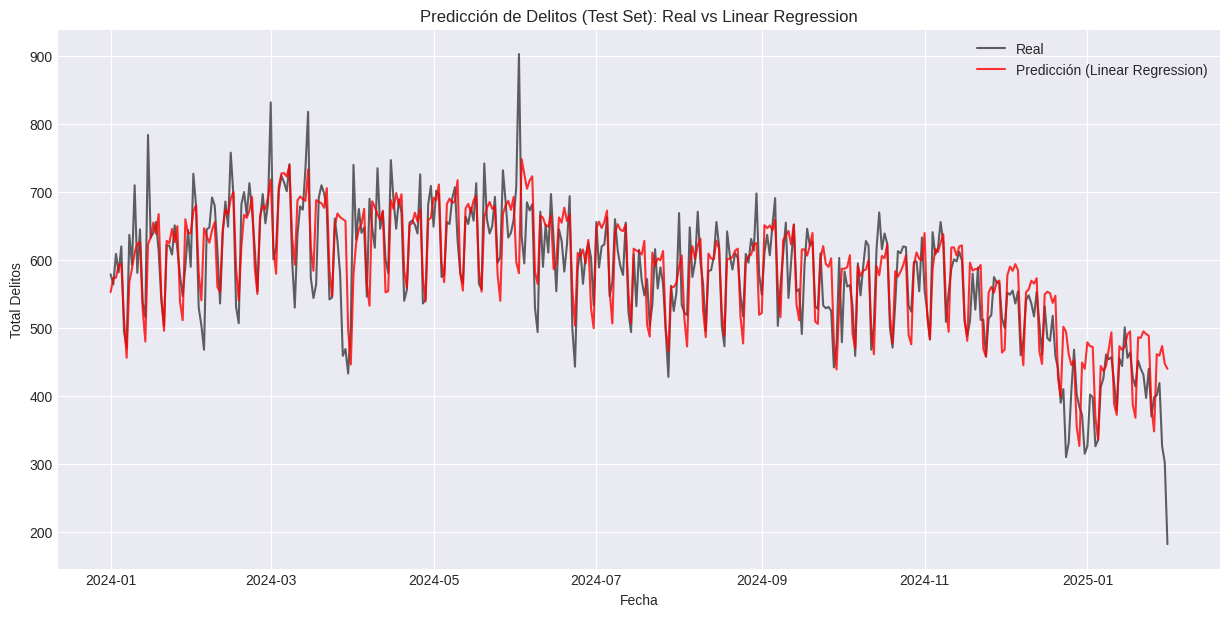

In [ ]:
# Visualizar predicciones del mejor modelo en Test
best_model_name = final_metrics["R2_Test"].idxmax()
print(f"\n⭐ Mejor modelo en Test: {best_model_name}")

best_preds = predictions_dict[best_model_name].select("fecha", "total_delitos", "prediction").toPandas()
best_preds['fecha'] = pd.to_datetime(best_preds['fecha'])
best_preds = best_preds.sort_values('fecha')

plt.figure(figsize=(15, 7))
plt.plot(best_preds['fecha'], best_preds['total_delitos'], label='Real', alpha=0.6, color='black')
plt.plot(best_preds['fecha'], best_preds['prediction'], label=f'Predicción ({best_model_name})', alpha=0.8, color='red')
plt.title(f'Predicción de Delitos (Test Set): Real vs {best_model_name}')
plt.xlabel('Fecha')
plt.ylabel('Total Delitos')
plt.legend()
plt.show()

In [ ]:
# Pronóstico Recursivo a Futuro (12 pasos)
print("\n🔮 Generando pronóstico recursivo a 12 días...")

def recursive_forecast(model, last_data_spark, steps=12):
    # Convertir últimos datos a Pandas para manipular features fácilmente
    # Necesitamos suficiente historia para calcular lags (30 días) y rolling (30 días)
    history_pd = last_data_spark.orderBy(F.col("fecha").desc()).limit(60).toPandas().sort_values("fecha")
    
    future_predictions = []
    
    current_date = history_pd['fecha'].iloc[-1]
    
    for _ in range(steps):
        next_date = current_date + pd.Timedelta(days=1)
        
        # Crear nueva fila base
        new_row = {'fecha': next_date}
        
        # Calcular Features de Calendario
        new_row['day_of_week'] = next_date.dayofweek + 1 # 1=Lunes, 7=Domingo (ajustar si Spark usa otro)
        new_row['day_of_month'] = next_date.day
        new_row['month'] = next_date.month
        new_row['is_weekend'] = 1 if new_row['day_of_week'] >= 6 else 0
        
        # Calcular Lags y Rolling (usando history_pd actualizado)
        # Lag 1 es el valor del día anterior (que puede ser una predicción)
        # Nota: 'total_delitos' en history_pd debe contener reales y predicciones pasadas
        
        # Lags
        lags = [1, 2, 3, 4, 5, 6, 7, 14, 30]
        for lag in lags:
            if len(history_pd) >= lag:
                new_row[f'lag_{lag}'] = history_pd['total_delitos'].iloc[-lag]
            else:
                new_row[f'lag_{lag}'] = 0 # Fallback
                
        # Rolling Stats
        # Pandas rolling incluye el valor actual por defecto si no se cierra, pero aquí queremos rolling de previos
        # Rolling 7 (excluyendo el actual que queremos predecir)
        new_row['rolling_mean_7'] = history_pd['total_delitos'].iloc[-7:].mean()
        new_row['rolling_std_7'] = history_pd['total_delitos'].iloc[-7:].std()
        new_row['rolling_mean_30'] = history_pd['total_delitos'].iloc[-30:].mean()
        
        # Crear DF de una fila para Spark
        # Necesitamos asegurar tipos de datos correctos
        # Spark espera tipos específicos, convertimos a float/int
        for k, v in new_row.items():
            if k != 'fecha':
                new_row[k] = float(v)
        
        # Dummy label para que VectorAssembler funcione (aunque no se use)
        new_row['total_delitos'] = 0.0 
        
        # Crear Spark DF
        # Schema debe coincidir con el de entrenamiento
        # Simplificación: crear DF desde pandas y dejar que Spark infiera, o usar el esquema de train_df
        input_pd = pd.DataFrame([new_row])
        input_spark = spark.createDataFrame(input_pd)
        
        # Predecir
        # Usamos el pipeline completo (assembler + scaler + model)
        # Pero trained_models[name] ya es el PipelineModel ajustado
        pred_df = trained_models[best_model_name].transform(input_spark)
        prediction = pred_df.select("prediction").collect()[0][0]
        
        # Guardar predicción
        future_predictions.append({'fecha': next_date, 'prediction': prediction})
        
        # Actualizar historia con la predicción (para usarla como lag en el siguiente paso)
        new_row['total_delitos'] = prediction
        history_pd = pd.concat([history_pd, pd.DataFrame([new_row])], ignore_index=True)
        
        current_date = next_date
        
    return pd.DataFrame(future_predictions)

# Ejecutar pronóstico con el mejor modelo
forecast_df = recursive_forecast(trained_models[best_model_name], daily_counts, steps=12)

# Visualizar Pronóstico
plt.figure(figsize=(12, 6))
# Mostrar últimos 30 días reales
last_real = daily_counts.orderBy(F.col("fecha").desc()).limit(30).toPandas().sort_values("fecha")
plt.plot(last_real['fecha'], last_real['total_delitos'], label='Histórico Reciente', marker='o', color='black')

# Mostrar pronóstico
plt.plot(forecast_df['fecha'], forecast_df['prediction'], label=f'Pronóstico 12 días ({best_model_name})', marker='o', linestyle='--', color='blue')

plt.title('Pronóstico de Delitos a Corto Plazo')
plt.xlabel('Fecha')
plt.ylabel('Total Delitos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📅 Valores Pronosticados:")
print(forecast_df)


In [ ]:
# Visualizar importancia de características (Solo para Random Forest o GBT)
if best_model_name in ["Random Forest", "Gradient Boosted Trees"]:
    print(f"\n🔍 Analizando importancia de variables para {best_model_name}...")
    
    # El modelo está en la posición 2 del pipeline entrenado (0: assembler, 1: scaler, 2: model)
    rf_model = trained_models[best_model_name].stages[2]
    importances = rf_model.featureImportances.toArray()
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title(f'Top 15 Features Más Importantes ({best_model_name})')
    plt.show()